# Notes on Hierarchical Hilbert Space Gaussian Processes

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
from jax import random, vmap
from jaxtyping import Array, Float32, UInt32
from xarray import DataArray  # noqa: F401

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

In [2]:
n = 300
x_full = jnp.linspace(0, 1, n)

In [3]:
def generate_single_group_data(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> Float32[Array, " n"]:
    """Generate one dimensional data for a single group.

    Parameters
    ----------
    rng_key : UInt32[Array, "2"]
        JAX random key.
    x : Float32[Array, " n"]
        Input domain data.

    Returns
    -------
    Float32[Array, " n"]
        Output data.
    """
    a1, a2, b = random.uniform(rng_key, minval=4, maxval=7, shape=(3,))
    return jnp.sin((a1 * jnp.pi) * x) + jnp.cos((a2 * jnp.pi) * x) + b


def dgg(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> tuple[Float32[Array, " n"], Float32[Array, " n"], Float32[Array, " n"]]:
    f_g = generate_single_group_data(rng_key, x)
    f = jnp.sin((4 * jnp.pi) * x) + jnp.sin((7 * jnp.pi) * x)
    noise = random.normal(rng_key, shape=(n,)) * 0.3
    y = f + f_g + noise
    return f_g, f, y


n_groups = 5

rng_key, rng_subkey = random.split(rng_key)

f_g, f, y = vmap(dgg)(
    random.split(rng_subkey, n_groups), jnp.tile(x_full, (n_groups, 1))
)

assert f_g.shape == (n_groups, n)
assert f.shape == (n_groups, n)
assert y.shape == (n_groups, n)

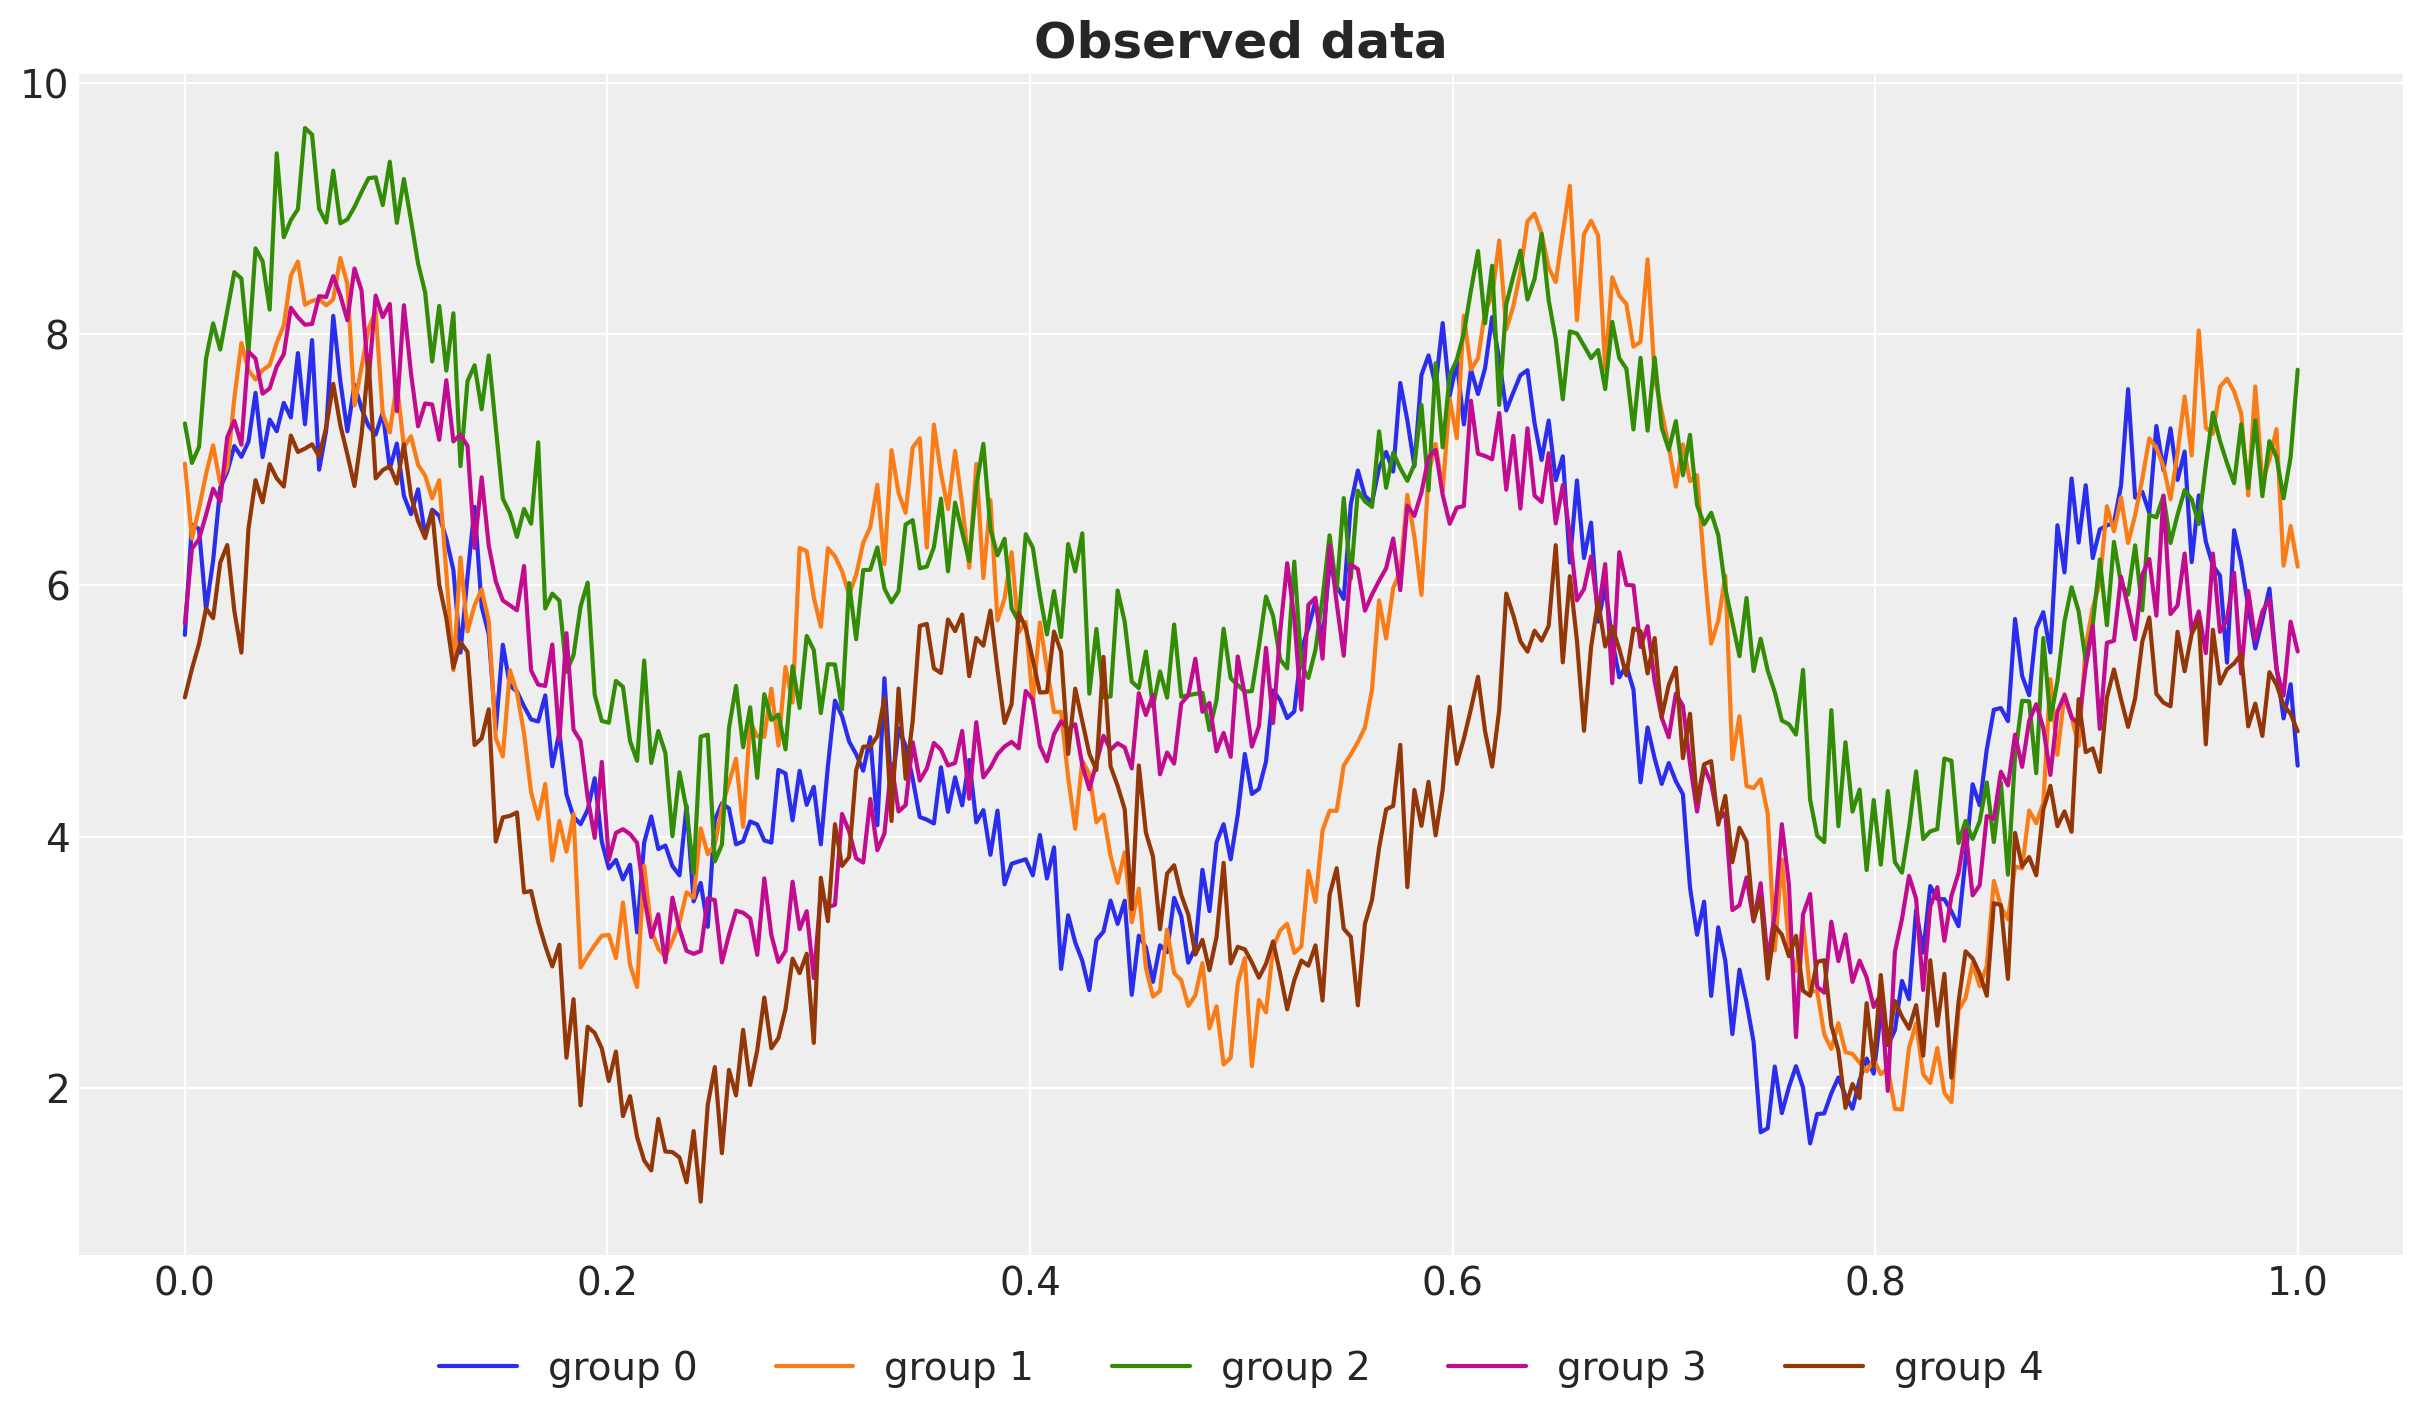

In [4]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x_full, y[g], label=f"group {g}")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data", fontsize=18, fontweight="bold");

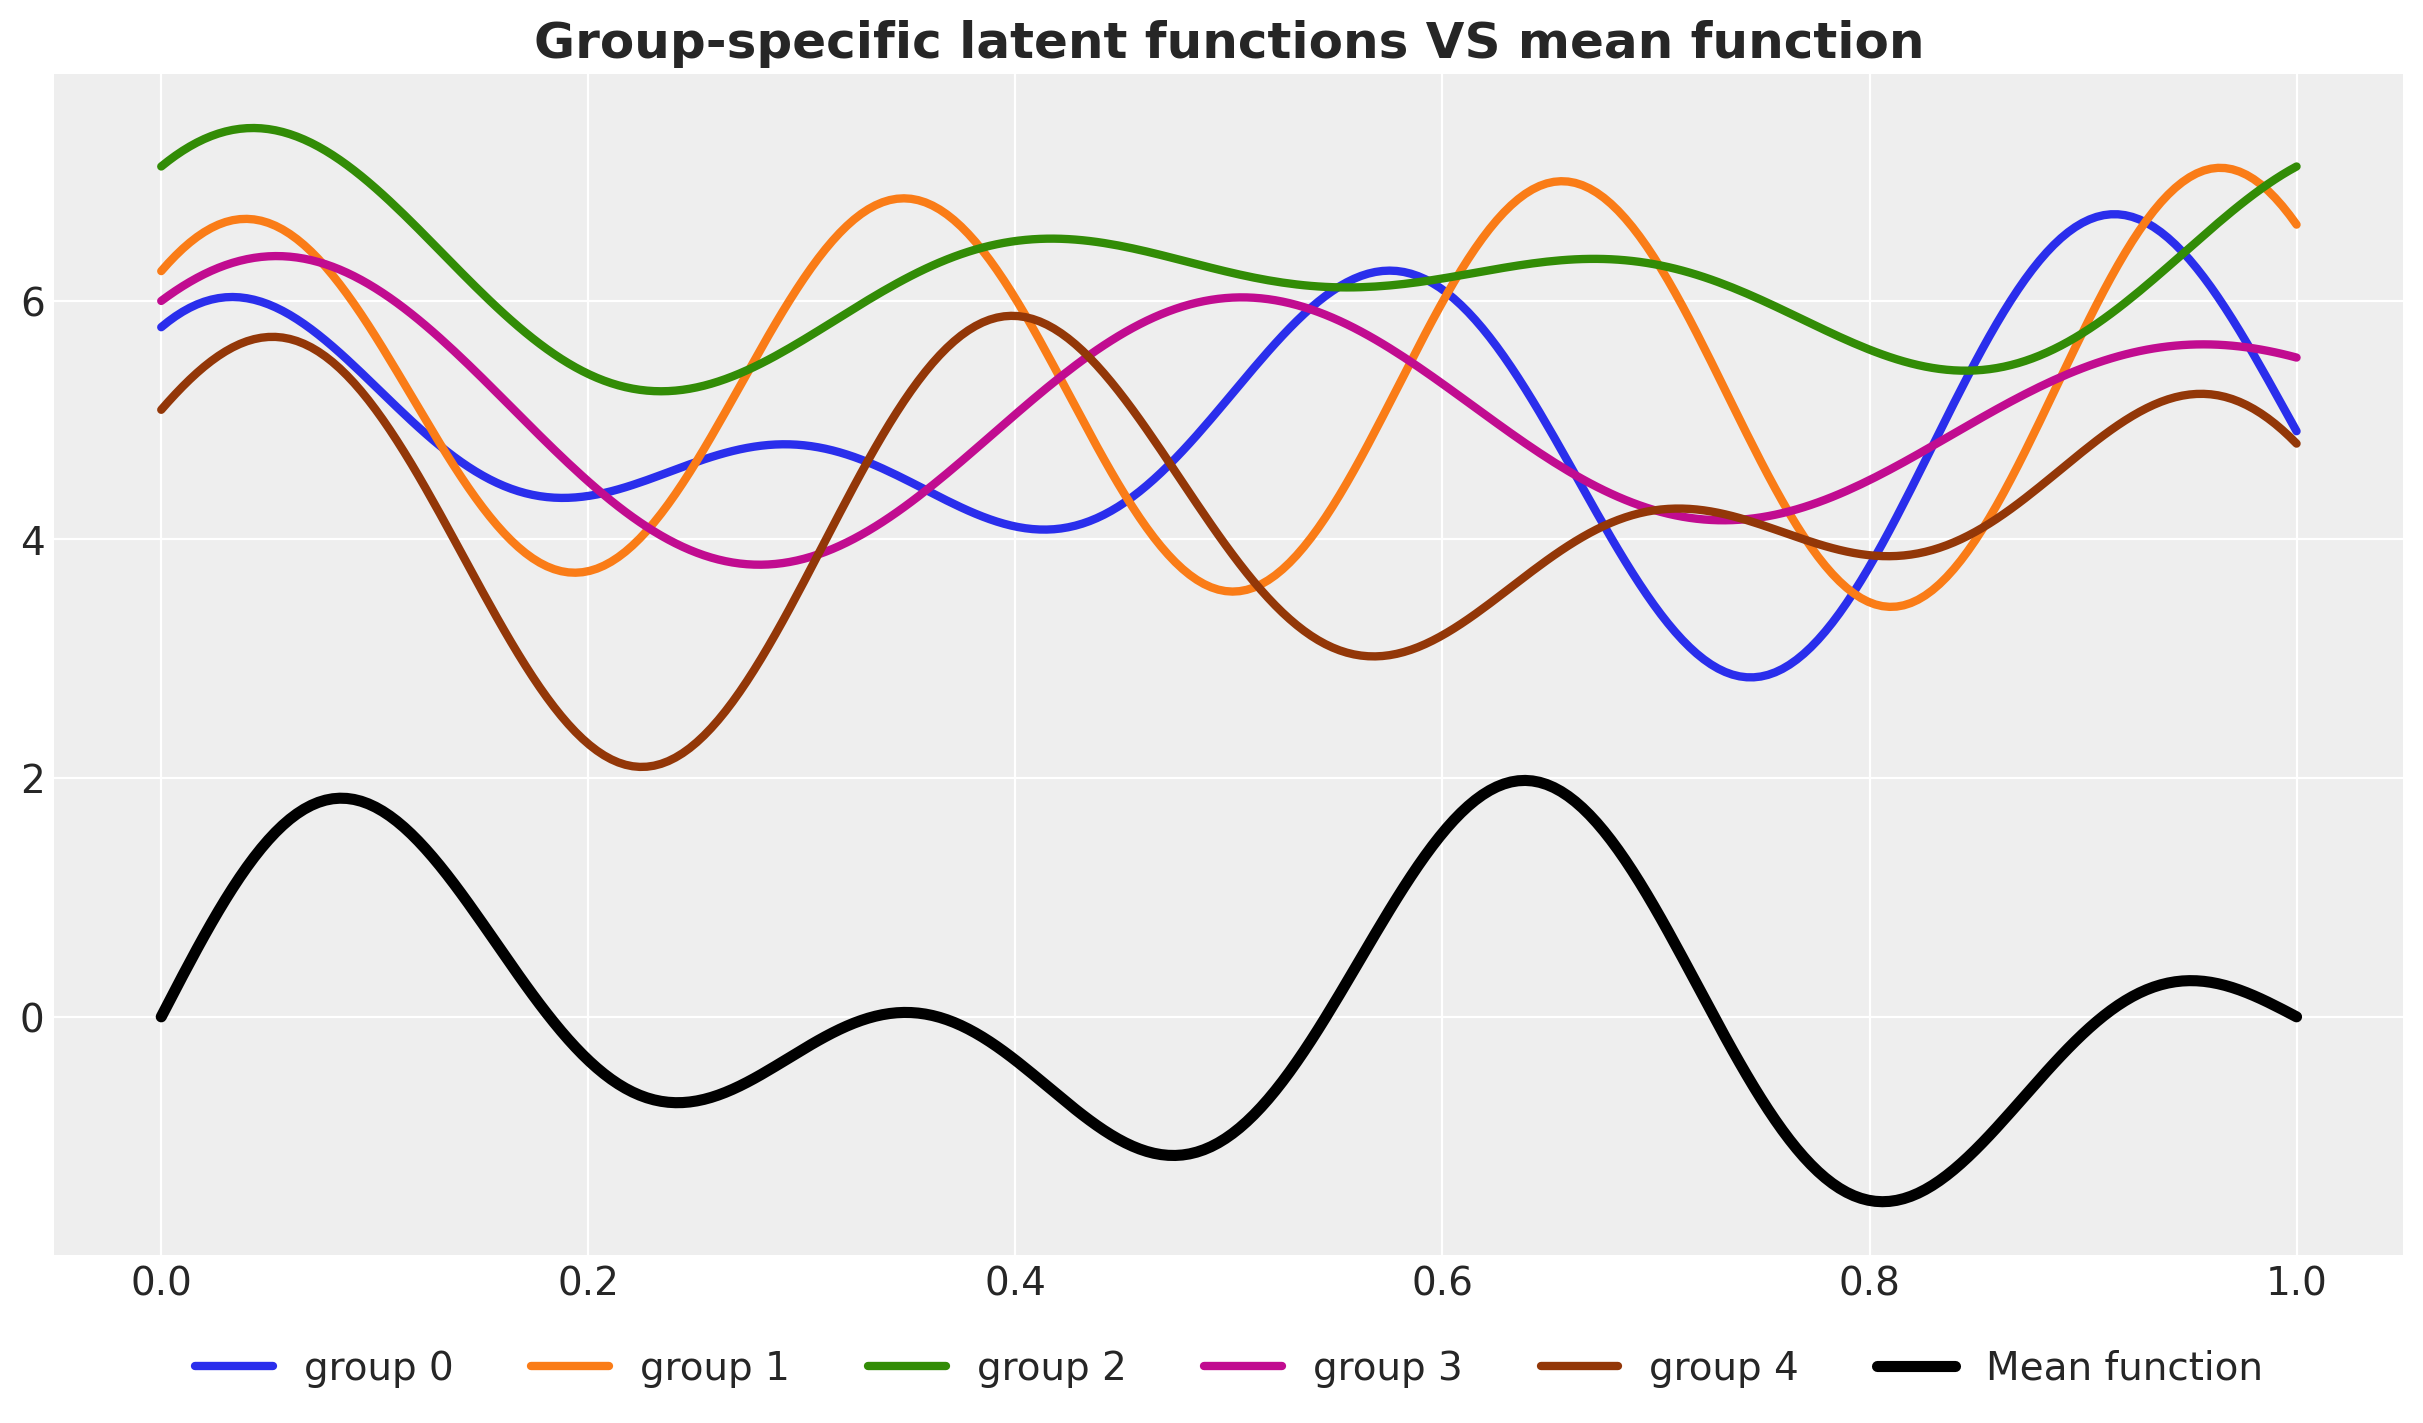

In [5]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x_full, f_g[g], lw=3, c=f"C{g}", label=f"group {g}")

ax.plot(x_full, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 1)
ax.set_title(
    "Group-specific latent functions VS mean function", fontsize=18, fontweight="bold"
);

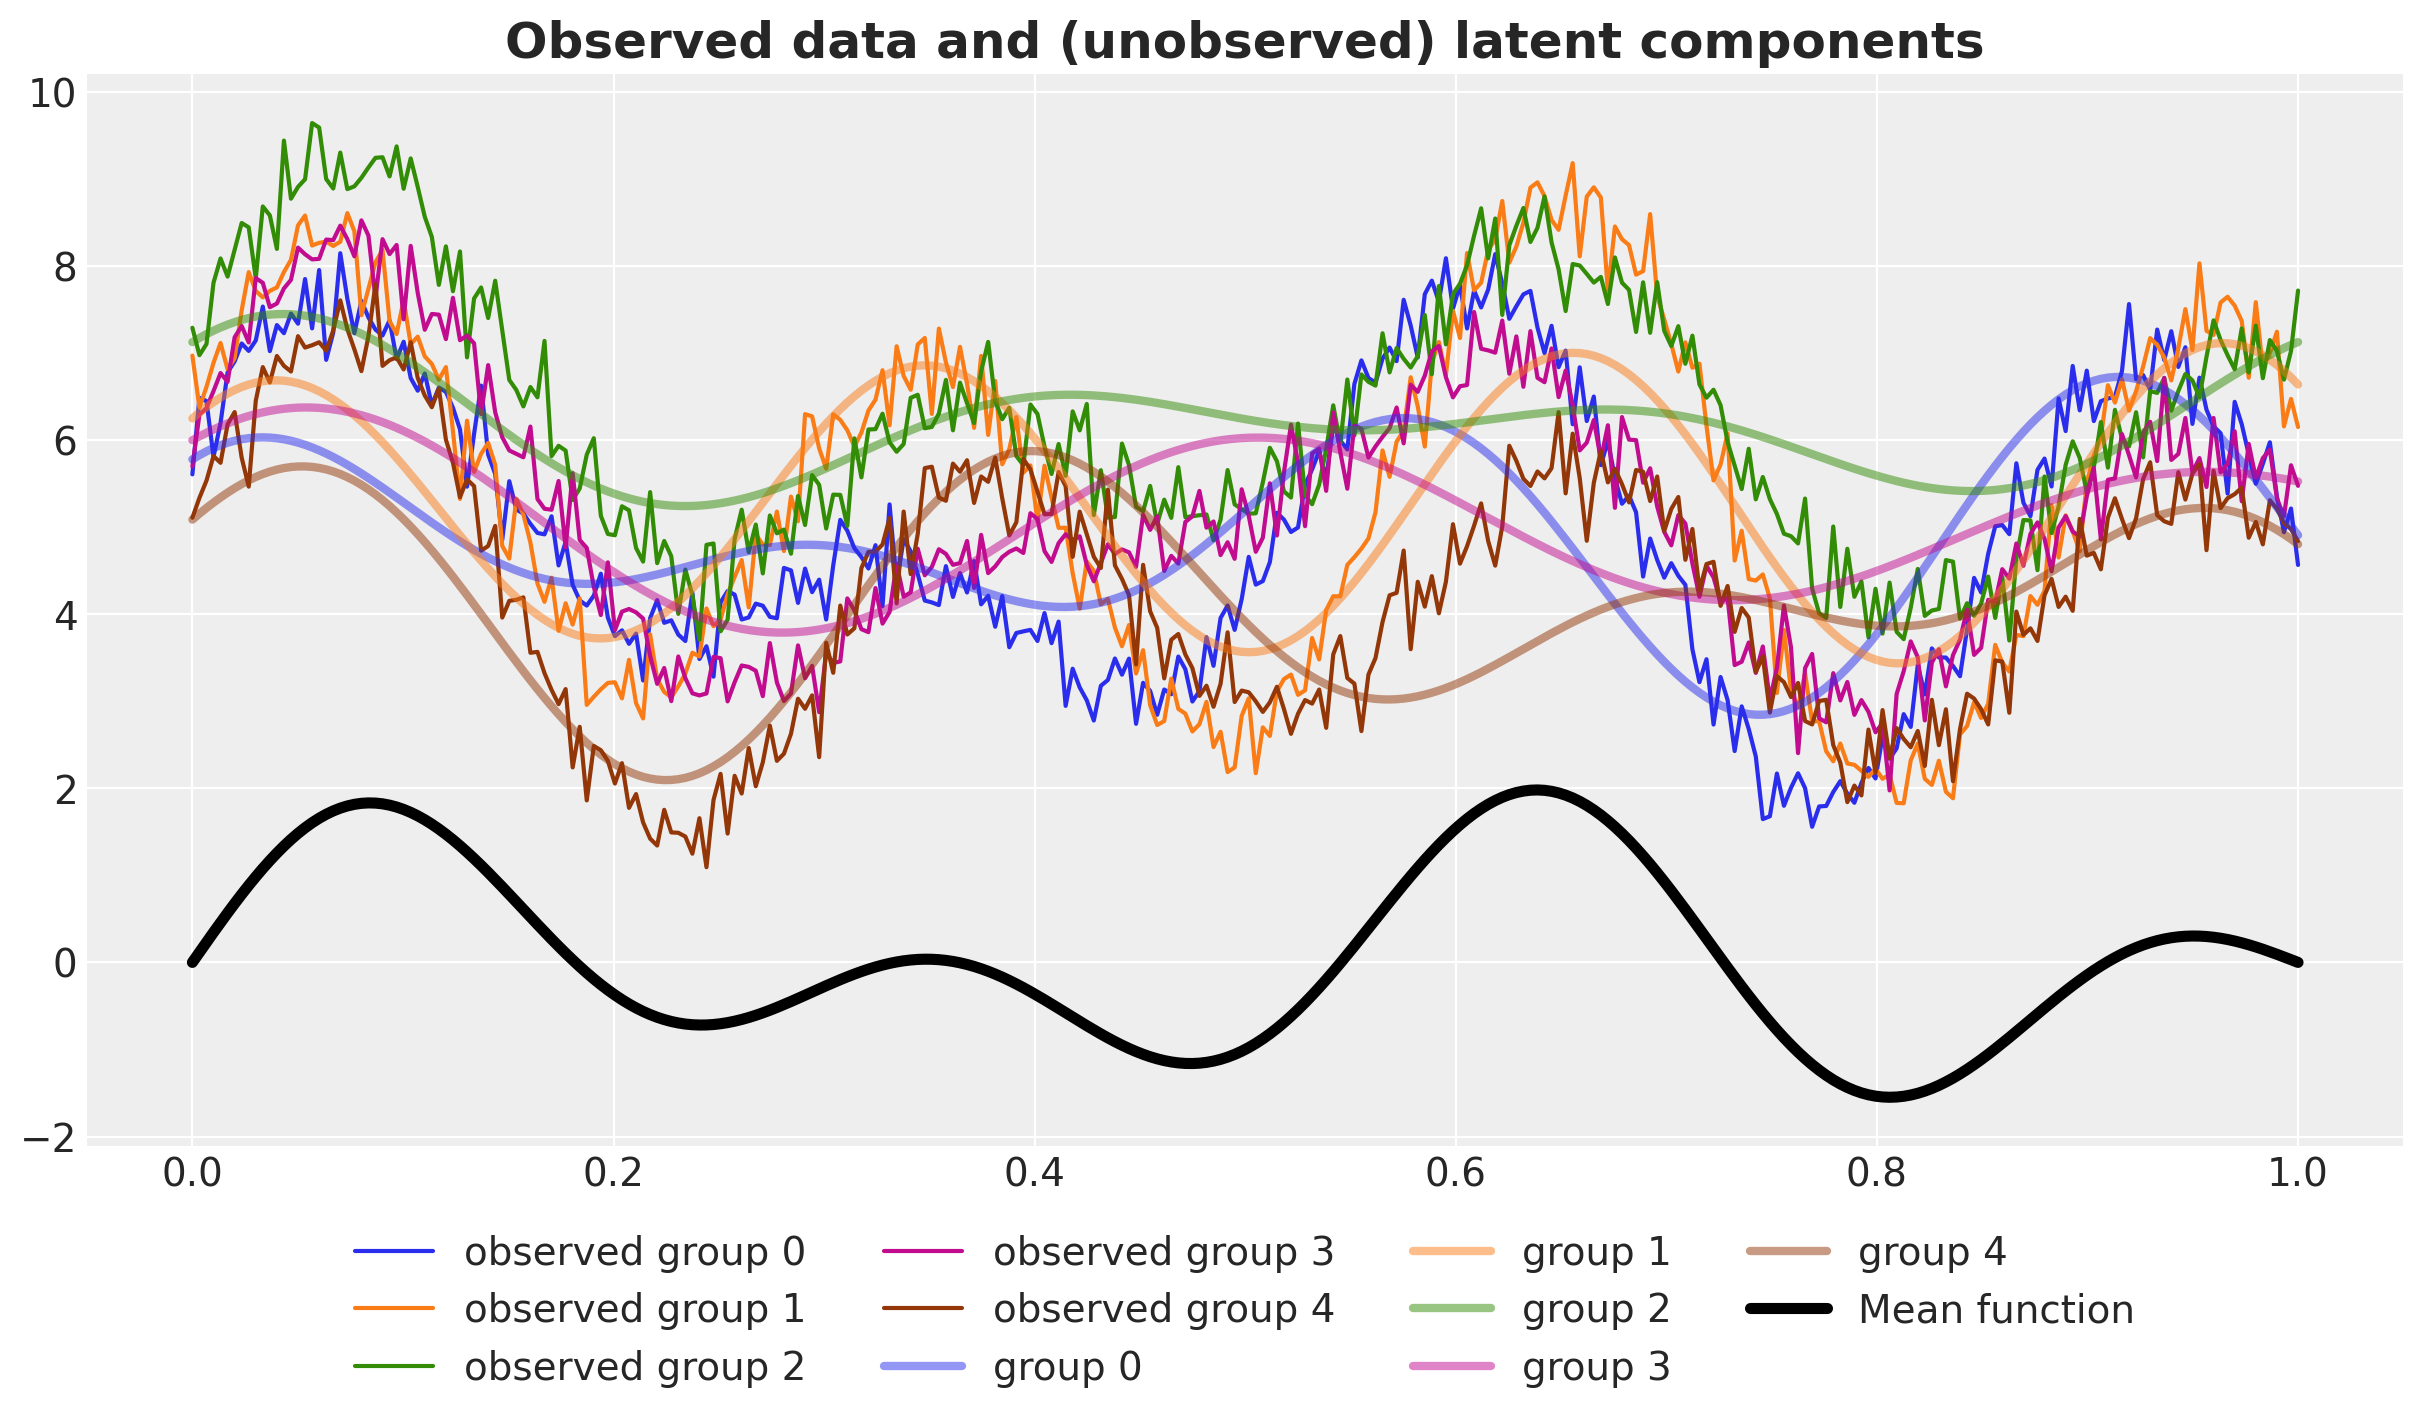

In [6]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x_full, y[g], label=f"observed group {g}")

for g in range(n_groups):
    ax.plot(x_full, f_g[g], lw=3, c=f"C{g}", alpha=0.5, label=f"group {g}")

ax.plot(x_full, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups - 1)
ax.set_title(
    "Observed data and (unobserved) latent components", fontsize=18, fontweight="bold"
);